# Membuat Machine Learning Pipeline

In [1]:
import tensorflow as tf
from tfx.components import CsvExampleGen, StatisticsGen, SchemaGen, ExampleValidator, Transform, Trainer, Tuner
from tfx.proto import example_gen_pb2
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Processing Data

In [2]:
df = pd.read_csv("tweets.csv", encoding="ISO-8859-1", names=['label','id','date','falg','user','tweet'])
df

,label,id,date,falg,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [3]:
df.drop(columns=["id", "date", "falg", "user"], inplace=True)
df

,label,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [4]:
pd.set_option('mode.chained_assignment', None)
for i in range(len(df.label)):
    if (df.label[i] == 4):
        df.label[i] = 1

df

,label,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


In [5]:
df.isnull().sum()

label    0
tweet    0
dtype: int64

In [6]:
df.duplicated().sum()

16309

In [7]:
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df.duplicated().sum()

0

In [8]:
df.dtypes

label     int64
tweet    object
dtype: object

In [9]:
df.groupby('label').count()

,tweet
label,
0,790185
1,793506


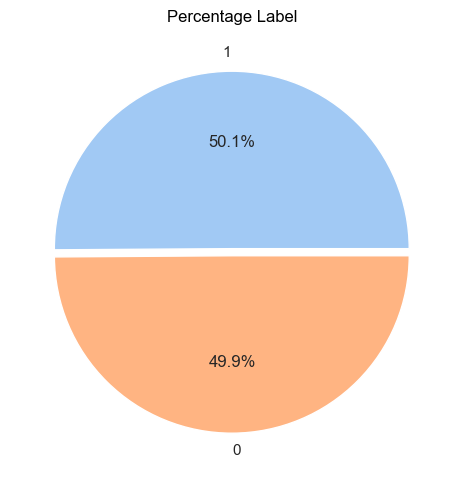

In [10]:
label_count = df['label'].value_counts()
fig,axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')
explode = [0.02]*len(label_count)

axes.pie(label_count.values, labels=label_count.index, autopct='%1.1f%%', colors=color, explode=explode)
axes.set_title('Percentage Label')

plt.tight_layout()
plt.show()

In [11]:
df.to_csv("data/data.csv", index=False)

### Set Variable

In [12]:
PIPELINE_NAME = "erwinapm-pipeline"
SCHEMA_PIPELINE_NAME = "erwinapm-tfdv-schema"

#Directory untuk menyimpan artifact yang akan dihasilkan
PIPELINE_ROOT = os.path.join('pipelines', PIPELINE_NAME)

# Path to a SQLite DB file to use as an MLMD storage.
METADATA_PATH = os.path.join('metadata', PIPELINE_NAME, 'metadata.db')

# Output directory where created models from the pipeline will be exported.
SERVING_MODEL_DIR = os.path.join('serving_model', PIPELINE_NAME)

In [13]:
DATA_ROOT = "data"

In [14]:
interactive_context = InteractiveContext(pipeline_root=PIPELINE_ROOT)

In [15]:
output = example_gen_pb2.Output(
    split_config = example_gen_pb2.SplitConfig(splits=[
        example_gen_pb2.SplitConfig.Split(name="train", hash_buckets=8),
        example_gen_pb2.SplitConfig.Split(name="eval", hash_buckets=2)
    ])
)
example_gen = CsvExampleGen(input_base=DATA_ROOT, output_config=output)
interactive_context.run(example_gen)

ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 1
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=CsvExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}))

In [16]:
statistics_gen = StatisticsGen(
    examples=example_gen.outputs["examples"]
)

interactive_context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 2
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}))

In [17]:
interactive_context.show(statistics_gen.outputs["statistics"])

In [18]:
schema_gen = SchemaGen(
    statistics=statistics_gen.outputs["statistics"]
)

interactive_context.run(schema_gen)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 3
    outputs:
        schema: OutputChannel(artifact_type=Schema, producer_component_id=SchemaGen, output_key=schema, additional_properties={}, additional_custom_properties={}))

In [19]:
interactive_context.show(schema_gen.outputs["schema"])

,Type,Presence,Valency,Domain
Feature name,,,,
'label',INT,required,,-
'tweet',BYTES,required,,-


In [20]:
example_validator = ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema']
)

interactive_context.run(example_validator)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 4
    outputs:
        anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=ExampleValidator, output_key=anomalies, additional_properties={}, additional_custom_properties={}))

In [21]:
interactive_context.show(example_validator.outputs['anomalies'])

In [22]:
TRANSFORM_MODULE_FILE = "tweets_transform.py"

In [23]:
%%writefile {TRANSFORM_MODULE_FILE}

import tensorflow as tf

LABEL_KEY = "label"
FEATURE_KEY = "tweet"
def transformed_name(key):
    """Renaming transformed features"""
    return key + "_xf"
def preprocessing_fn(inputs):
    """
    Preprocess input features into transformed features
    
    Args:
        inputs: map from feature keys to raw features.
    
    Return:
        outputs: map from feature keys to transformed features.    
    """
    
    outputs = {}
    
    outputs[transformed_name(FEATURE_KEY)] = tf.strings.lower(inputs[FEATURE_KEY])
    
    outputs[transformed_name(LABEL_KEY)] = tf.cast(inputs[LABEL_KEY], tf.int64)
    
    return outputs

Writing tweets_transform.py


In [24]:
transform  = Transform(
    examples=example_gen.outputs['examples'],
    schema= schema_gen.outputs['schema'],
    module_file=os.path.abspath(TRANSFORM_MODULE_FILE)
)

interactive_context.run(transform)

Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.


INFO:tensorflow:Assets written to: pipelines\erwinapm-pipeline\Transform\transform_graph\5\.temp_path\tftransform_tmp\54365dbce64c43cd81111f764c79c618\assets


INFO:tensorflow:Assets written to: pipelines\erwinapm-pipeline\Transform\transform_graph\5\.temp_path\tftransform_tmp\54365dbce64c43cd81111f764c79c618\assets


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


ExecutionResult(
    component_id: Transform
    execution_id: 5
    outputs:
        transform_graph: OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={})
        transformed_examples: OutputChannel(artifact_type=Examples, producer_component_id=Transform, output_key=transformed_examples, additional_properties={}, additional_custom_properties={})
        updated_analyzer_cache: OutputChannel(artifact_type=TransformCache, producer_component_id=Transform, output_key=updated_analyzer_cache, additional_properties={}, additional_custom_properties={})
        pre_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=pre_transform_schema, additional_properties={}, additional_custom_properties={})
        pre_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=pre_transform_stats, additional_properties={}, additional_custom_properties={})
        post_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=post_transform_schema, additional_properties={}, additional_custom_properties={})
        post_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=post_transform_stats, additional_properties={}, additional_custom_properties={})
        post_transform_anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=Transform, output_key=post_transform_anomalies, additional_properties={}, additional_custom_properties={}))

In [25]:
TUNER_MODULE_FILE = "tweets_tuner.py"

In [26]:
%%writefile {TUNER_MODULE_FILE}
from keras_tuner.engine import base_tuner
import tensorflow as tf
import tensorflow_transform as tft 
from tensorflow.keras import layers
import os  
import tensorflow_hub as hub
from tfx.components.trainer.fn_args_utils import FnArgs
import keras_tuner
import keras
from typing import NamedTuple, Dict, Text, Any

LABEL_KEY = "label"
FEATURE_KEY = "tweet"
VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 100
embedding_dim=16

def transformed_name(key):
    """Renaming transformed features"""
    return key + "_xf"
 
def gzip_reader_fn(filenames):
    """Loads compressed data"""
    return tf.data.TFRecordDataset(filenames, compression_type='GZIP')

def input_fn(file_pattern, 
             tf_transform_output,
             num_epochs,
             batch_size=64)->tf.data.Dataset:
    """Get post_tranform feature & create batches of data"""
    
    # Get post_transform feature spec
    transform_feature_spec = (
        tf_transform_output.transformed_feature_spec().copy())
    
    # create batches of data
    dataset = tf.data.experimental.make_batched_features_dataset(
        file_pattern=file_pattern,
        batch_size=batch_size,
        features=transform_feature_spec,
        reader=gzip_reader_fn,
        num_epochs=num_epochs,
        label_key = transformed_name(LABEL_KEY))
    return dataset

vectorize_layer = layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', mode='max', verbose=1, patience=10)

def model_builder(hp):
    """Build machine learning model"""
    inputs = tf.keras.Input(shape=(1,), name=transformed_name(FEATURE_KEY), dtype=tf.string)
    reshaped_narrative = tf.reshape(inputs, [-1])
    x = vectorize_layer(reshaped_narrative)
    x = layers.Embedding(VOCAB_SIZE, embedding_dim, name="embedding")(x)
    x = layers.GlobalAveragePooling1D()(x)
    hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    x = layers.Dense(units=hp_units1, activation='relu')(x)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    
    model = tf.keras.Model(inputs=inputs, outputs = outputs)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        loss = 'binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    
    )
    
    return model


TunerFnResult = NamedTuple('TunerFnResult', [('tuner', base_tuner.BaseTuner),
                                             ('fit_kwargs', Dict[Text, Any])])

def tuner_fn(fn_args: FnArgs) -> TunerFnResult:
    """Build the tuner using the KerasTuner API.
    Args:
    fn_args: Holds args used to tune models as name/value pairs.

    Returns:
    A namedtuple contains the following:
      - tuner: A BaseTuner that will be used for tuning.
      - fit_kwargs: Args to pass to tuner's run_trial function for fitting the
                    model , e.g., the training and validation dataset. Required
                    args depend on the above tuner's implementation.
    """
    # Memuat training dan validation dataset yang telah di-preprocessing
    tf_transform_output = tft.TFTransformOutput(fn_args.transform_graph_path)
    train_set = input_fn(fn_args.train_files, tf_transform_output, 10)
    val_set = input_fn(fn_args.eval_files, tf_transform_output, 10)
    vectorize_layer.adapt(
        [j[0].numpy()[0] for j in [
            i[0][transformed_name(FEATURE_KEY)]
                for i in list(train_set)]])

    # Mendefinisikan strategi hyperparameter tuning
    tuner = keras_tuner.RandomSearch(
        hypermodel = lambda hp: model_builder(keras_tuner.HyperParameters()),
        objective = keras_tuner.Objective('binary_accuracy', direction='max'),
        max_trials = 3,
        overwrite = True,
        directory = fn_args.working_dir,
        project_name = "kt_RandomSearch",
    )
    
    tuner.search(x = train_set, epochs=5, validation_data=val_set)
    
    return TunerFnResult(
        tuner=tuner,
        fit_kwargs={ 
            "callbacks":[stop_early],
            'x': train_set,
            'validation_data': val_set,
            'steps_per_epoch': fn_args.train_steps,
            'validation_steps': fn_args.eval_steps
        }
    )

    

Writing tweets_tuner.py


In [27]:
from tfx.components import Tuner
from tfx.proto import trainer_pb2

tuner = Tuner(
    module_file=os.path.abspath(TUNER_MODULE_FILE),
    examples=transform.outputs['transformed_examples'],
    transform_graph=transform.outputs['transform_graph'],
    schema=schema_gen.outputs['schema'],
    train_args=trainer_pb2.TrainArgs(splits=['train'], num_steps=500),
    eval_args=trainer_pb2.EvalArgs(splits=['eval'], num_steps=100)
    )

interactive_context.run(tuner)

Trial 1 Complete [01h 09m 30s]
binary_accuracy: 0.9961593747138977

Best binary_accuracy So Far: 0.9961593747138977
Total elapsed time: 01h 09m 30s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Search space summary
Default search space size: 0
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Results summary
Results in pipelines\erwinapm-pipeline\.temp\6\kt_RandomSearch
Showing 10 best trials
Objective(name="binary_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
default configuration
Score: 0.9961593747138977


ExecutionResult(
    component_id: Tuner
    execution_id: 6
    outputs:
        best_hyperparameters: OutputChannel(artifact_type=HyperParameters, producer_component_id=Tuner, output_key=best_hyperparameters, additional_properties={}, additional_custom_properties={})
        tuner_results: OutputChannel(artifact_type=TunerResults, producer_component_id=Tuner, output_key=tuner_results, additional_properties={}, additional_custom_properties={}))

In [28]:
TRAINER_MODULE_FILE = "tweets_trainer.py"

In [29]:
%%writefile {TRAINER_MODULE_FILE}
import tensorflow as tf
import tensorflow_transform as tft 
from tensorflow.keras import layers
import os  
import tensorflow_hub as hub
from tfx.components.trainer.fn_args_utils import FnArgs
 
LABEL_KEY = "label"
FEATURE_KEY = "tweet"
 
def transformed_name(key):
    """Renaming transformed features"""
    return key + "_xf"
 
def gzip_reader_fn(filenames):
    """Loads compressed data"""
    return tf.data.TFRecordDataset(filenames, compression_type='GZIP')
 
 
def input_fn(file_pattern, 
             tf_transform_output,
             num_epochs,
             batch_size=64)->tf.data.Dataset:
    """Get post_tranform feature & create batches of data"""
    
    # Get post_transform feature spec
    transform_feature_spec = (
        tf_transform_output.transformed_feature_spec().copy())
    
    # create batches of data
    dataset = tf.data.experimental.make_batched_features_dataset(
        file_pattern=file_pattern,
        batch_size=batch_size,
        features=transform_feature_spec,
        reader=gzip_reader_fn,
        num_epochs=num_epochs,
        label_key = transformed_name(LABEL_KEY))
    return dataset
 
# os.environ['TFHUB_CACHE_DIR'] = '/hub_chace'
# embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4")
 
# Vocabulary size and number of words in a sequence.
VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 100
 
vectorize_layer = layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH)
 
 
embedding_dim=16
def model_builder():
    """Build machine learning model"""
    inputs = tf.keras.Input(shape=(1,), name=transformed_name(FEATURE_KEY), dtype=tf.string)
    reshaped_narrative = tf.reshape(inputs, [-1])
    x = vectorize_layer(reshaped_narrative)
    x = layers.Embedding(VOCAB_SIZE, embedding_dim, name="embedding")(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    
    model = tf.keras.Model(inputs=inputs, outputs = outputs)
    
    model.compile(
        loss = 'binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(0.01),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    
    )
    
    model.summary()
    return model 
 
 
def _get_serve_tf_examples_fn(model, tf_transform_output):
    
    model.tft_layer = tf_transform_output.transform_features_layer()
    
    @tf.function
    def serve_tf_examples_fn(serialized_tf_examples):
        
        feature_spec = tf_transform_output.raw_feature_spec()
        
        feature_spec.pop(LABEL_KEY)
        
        parsed_features = tf.io.parse_example(serialized_tf_examples, feature_spec)
        
        transformed_features = model.tft_layer(parsed_features)
        
        # get predictions using the transformed features
        return model(transformed_features)
        
    return serve_tf_examples_fn
    
def run_fn(fn_args: FnArgs) -> None:
    
    log_dir = os.path.join(os.path.dirname(fn_args.serving_model_dir), 'logs')
    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir = log_dir, update_freq='batch'
    )
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', mode='max', verbose=1, patience=10)
    mc = tf.keras.callbacks.ModelCheckpoint(fn_args.serving_model_dir, monitor='val_binary_accuracy', mode='max', verbose=1, save_best_only=True)
    
    
    # Load the transform output
    tf_transform_output = tft.TFTransformOutput(fn_args.transform_graph_path)
    
    # Create batches of data
    train_set = input_fn(fn_args.train_files, tf_transform_output, 10)
    val_set = input_fn(fn_args.eval_files, tf_transform_output, 10)
    vectorize_layer.adapt(
        [j[0].numpy()[0] for j in [
            i[0][transformed_name(FEATURE_KEY)]
                for i in list(train_set)]])
    
    # Build the model
    model = model_builder()
    
    
    # Train the model
    model.fit(x = train_set,
            validation_data = val_set,
            callbacks = [tensorboard_callback, es, mc],
            steps_per_epoch = 1000, 
            validation_steps= 1000,
            epochs=30)
    signatures = {
        'serving_default':
        _get_serve_tf_examples_fn(model, tf_transform_output).get_concrete_function(
                                    tf.TensorSpec(
                                    shape=[None],
                                    dtype=tf.string,
                                    name='examples'))
    }
    model.save(fn_args.serving_model_dir, save_format='tf', signatures=signatures)

Writing tweets_trainer.py


In [30]:
from tfx.proto import trainer_pb2

trainer  = Trainer(
    module_file=os.path.abspath(TRAINER_MODULE_FILE),
    examples = transform.outputs['transformed_examples'],
    transform_graph=transform.outputs['transform_graph'],
    schema=schema_gen.outputs['schema'],
    hyperparameters=tuner.outputs['best_hyperparameters'],
    train_args=trainer_pb2.TrainArgs(splits=['train']),
    eval_args=trainer_pb2.EvalArgs(splits=['eval'])
)

interactive_context.run(trainer)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tweet_xf (InputLayer)       [(None, 1)]               0         
                                                                 
 tf.reshape_1 (TFOpLambda)   (None,)                   0         
                                                                 
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 64)                1088

INFO:tensorflow:Assets written to: pipelines\erwinapm-pipeline\Trainer\model\7\Format-Serving\assets


1000/1000 [==============================] - 10s 9ms/step - loss: 0.0050 - binary_accuracy: 0.9999 - val_loss: 1.9533e-04 - val_binary_accuracy: 1.0000
Epoch 2/30
 995/1000 [============================>.] - ETA: 0s - loss: 0.0020 - binary_accuracy: 0.9999
Epoch 2: val_binary_accuracy did not improve from 0.99998
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0020 - binary_accuracy: 0.9999 - val_loss: 3.4887e-04 - val_binary_accuracy: 1.0000
Epoch 3/30
 998/1000 [============================>.] - ETA: 0s - loss: 0.0023 - binary_accuracy: 0.9998
Epoch 3: val_binary_accuracy improved from 0.99998 to 1.00000, saving model to pipelines\erwinapm-pipeline\Trainer\model\7\Format-Serving
INFO:tensorflow:Assets written to: pipelines\erwinapm-pipeline\Trainer\model\7\Format-Serving\assets


INFO:tensorflow:Assets written to: pipelines\erwinapm-pipeline\Trainer\model\7\Format-Serving\assets


1000/1000 [==============================] - 8s 8ms/step - loss: 0.0023 - binary_accuracy: 0.9998 - val_loss: 1.7484e-05 - val_binary_accuracy: 1.0000
Epoch 4/30
 994/1000 [============================>.] - ETA: 0s - loss: 0.0025 - binary_accuracy: 0.9998
Epoch 4: val_binary_accuracy did not improve from 1.00000
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0025 - binary_accuracy: 0.9998 - val_loss: 1.9518e-04 - val_binary_accuracy: 1.0000
Epoch 5/30
 992/1000 [============================>.] - ETA: 0s - loss: 0.0013 - binary_accuracy: 0.9999
Epoch 5: val_binary_accuracy did not improve from 1.00000
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0013 - binary_accuracy: 0.9999 - val_loss: 7.4618e-06 - val_binary_accuracy: 1.0000
Epoch 6/30
 989/1000 [============================>.] - ETA: 0s - loss: 0.0021 - binary_accuracy: 0.9998
Epoch 6: val_binary_accuracy did not improve from 1.00000
1000/1000 [==============================] - 7s 7ms/step -

INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:Assets written to: pipelines\erwinapm-pipeline\Trainer\model\7\Format-Serving\assets


INFO:tensorflow:Assets written to: pipelines\erwinapm-pipeline\Trainer\model\7\Format-Serving\assets


ExecutionResult(
    component_id: Trainer
    execution_id: 7
    outputs:
        model: OutputChannel(artifact_type=Model, producer_component_id=Trainer, output_key=model, additional_properties={}, additional_custom_properties={})
        model_run: OutputChannel(artifact_type=ModelRun, producer_component_id=Trainer, output_key=model_run, additional_properties={}, additional_custom_properties={}))

In [31]:
from tfx.dsl.components.common.resolver import Resolver
from tfx.dsl.input_resolution.strategies.latest_blessed_model_strategy import LatestBlessedModelStrategy
from tfx.types import Channel
from tfx.types.standard_artifacts import Model, ModelBlessing

model_resolver = Resolver(
    strategy_class= LatestBlessedModelStrategy,
    model = Channel(type=Model),
    model_blessing = Channel(type=ModelBlessing)
).with_id('Latest_blessed_model_resolver')

interactive_context.run(model_resolver)

ExecutionResult(
    component_id: Latest_blessed_model_resolver
    execution_id: 8
    outputs:
        model: OutputChannel(artifact_type=Model, producer_component_id=Latest_blessed_model_resolver, output_key=model, additional_properties={}, additional_custom_properties={})
        model_blessing: OutputChannel(artifact_type=ModelBlessing, producer_component_id=Latest_blessed_model_resolver, output_key=model_blessing, additional_properties={}, additional_custom_properties={}))

In [32]:
import tensorflow_model_analysis as tfma

eval_config = tfma.EvalConfig(
    model_specs=[tfma.ModelSpec(label_key='label')],
    slicing_specs=[tfma.SlicingSpec()],
    metrics_specs=[
        tfma.MetricsSpec(metrics=[
            tfma.MetricConfig(class_name='ExampleCount'),
            tfma.MetricConfig(class_name='AUC'),
            tfma.MetricConfig(class_name='FalsePositives'),
            tfma.MetricConfig(class_name='TruePositives'),
            tfma.MetricConfig(class_name='FalseNegatives'),
            tfma.MetricConfig(class_name='TrueNegatives'),
            tfma.MetricConfig(class_name='BinaryAccuracy',
                threshold=tfma.MetricThreshold(
                    value_threshold=tfma.GenericValueThreshold(
                        lower_bound={'value':0.5}),
                    change_threshold=tfma.GenericChangeThreshold(
                        direction=tfma.MetricDirection.HIGHER_IS_BETTER,
                        absolute={'value':0.0001})
                    )
            )
        ])
    ]
)

In [33]:
from tfx.components import Evaluator
evaluator = Evaluator(
    examples=example_gen.outputs['examples'],
    model=trainer.outputs['model'],
    baseline_model=model_resolver.outputs['model'],
    eval_config=eval_config
)

interactive_context.run(evaluator)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


ExecutionResult(
    component_id: Evaluator
    execution_id: 9
    outputs:
        evaluation: OutputChannel(artifact_type=ModelEvaluation, producer_component_id=Evaluator, output_key=evaluation, additional_properties={}, additional_custom_properties={})
        blessing: OutputChannel(artifact_type=ModelBlessing, producer_component_id=Evaluator, output_key=blessing, additional_properties={}, additional_custom_properties={}))

In [34]:
# Visualize the evaluation results
eval_result = evaluator.outputs['evaluation'].get()[0].uri
tfma_result = tfma.load_eval_result(eval_result)
tfma.view.render_slicing_metrics(tfma_result)
data_tfma = tfma.addons.fairness.view.widget_view.render_fairness_indicator(
    tfma_result
)
print(tfma_result)

EvalResult(slicing_metrics=[((), {'': {'': {'binary_accuracy': {'doubleValue': 0.49962212841309744}, 'loss': {'doubleValue': 7.552222728729248}, 'example_count': {'doubleValue': 316245.0}, 'auc': {'doubleValue': 0.6570565880649305}, 'false_positives': {'doubleValue': 158242.0}, 'true_positives': {'doubleValue': 158003.0}, 'false_negatives': {'doubleValue': 0.0}, 'true_negatives': {'doubleValue': 0.0}}}})], plots=[((), None)], attributions=[((), None)], config=model_specs {
  label_key: "label"
}
slicing_specs {
}
metrics_specs {
  metrics {
    class_name: "ExampleCount"
  }
  metrics {
    class_name: "AUC"
  }
  metrics {
    class_name: "FalsePositives"
  }
  metrics {
    class_name: "TruePositives"
  }
  metrics {
    class_name: "FalseNegatives"
  }
  metrics {
    class_name: "TrueNegatives"
  }
  metrics {
    class_name: "BinaryAccuracy"
    threshold {
      value_threshold {
        lower_bound {
          value: 0.5
        }
      }
    }
  }
  model_names: ""
}
, data_loc

In [35]:
from tfx.components import Pusher
from tfx.proto import pusher_pb2

pusher = Pusher(
model=trainer.outputs['model'],
model_blessing=evaluator.outputs['blessing'],
push_destination=pusher_pb2.PushDestination(
    filesystem=pusher_pb2.PushDestination.Filesystem(
        base_directory='serving_model_dir/tweet-detection-model'))
)

interactive_context.run(pusher)

ExecutionResult(
    component_id: Pusher
    execution_id: 10
    outputs:
        pushed_model: OutputChannel(artifact_type=PushedModel, producer_component_id=Pusher, output_key=pushed_model, additional_properties={}, additional_custom_properties={}))

In [36]:
import requests
from pprint import PrettyPrinter

pp = PrettyPrinter()
pp.pprint(requests.get("http://localhost:8080/v1/models/tweet-detection-model").json())

{'model_version_status': [{'state': 'AVAILABLE',
                           'status': {'error_code': 'OK', 'error_message': ''},
                           'version': '1710973572'}]}
